# Thermodynamic model implementation

Once working this will need to mostly go in a module. Until then it's here.

This implements the Fe-FeO thermodynamic model of Komabayashi 2014
(Thermodynamics of melting relations in the system Fe-FeO at high pressure:
Implications for oxygen in the Earth’s core, JGR 119, 4164-4177,
http://dx.doi.org/10.1002/2014JB010980). 

There are, I think, six steps:

1) Evaluate G(1bar, T) for HPC Fe, FeO and both liquids from equation 2 (polynomial evaluation) 

2) Evaluate V at a set of pressures between 1 bar and P at 298 K from equation 3 (root finding)

3) Evaluate alpha at each V from equation 5 (evaluate function)

4) Assume alpha does not vary with T and thermally expand each V from 298K (step 2) to T (evaluate function)

5) Integrate V (from step 4) from 1 bar to P and add to G(1bar, T) (equation 2, numerical integration).

This gives our end member free energies / chemical potentials. Then.

6) Calculate chemical potentials in liquid at composition X from equation 7. It looks like we'll want the ideal solid solution model as the non-ideal one (which comes from Frost) is clearly broken when extrapolated to high pressure. Add the chemical potentials to get the free energy of the liquid.

In [1]:
import numpy as np
import scipy.optimize as spo
import matplotlib.pyplot as plt
import matplotlib
import numba
%matplotlib inline

## Parameters

Put all the parameters here....

In [2]:
# Things marked 'old model' are from Komabayashi and Fei 2010 (doi: 10.1029/2009/JB006442)
# Fe parameters (hcp and liquid) match those in Komabayashi 2020 
# (https://link.springer.com/article/10.1007/s00269-020-01102-w)

fe_fcc_a = 16300.921
fe_fcc_b = 381.47162
fe_fcc_c = -52.2754
fe_fcc_d = 0.000177578
fe_fcc_e = -395355.43
fe_fcc_f = -2476.28
fe_fcc_v0 = 6.82
fe_fcc_k0 = 163.4
fe_fcc_kp = 5.38
fe_fcc_a0 = 7.0e-5
fe_fcc_ag0 = 5.5
fe_fcc_k = 1.4

fe_hcp_a = 12460.921
fe_hcp_b = 386.99162
# fe_hcp_a = 14405.9211 # old model
# fe_hcp_b = 384.8716162 # old model
fe_hcp_c = -52.2754
fe_hcp_d = 0.000177578
fe_hcp_e = -395355.43
fe_hcp_f = -2476.28
fe_hcp_v0 = 6.753
fe_hcp_k0 = 163.4
fe_hcp_kp = 5.38
fe_hcp_a0 = 5.8e-5
fe_hcp_ag0 = 5.1
fe_hcp_k = 1.4

fe_liquid_a = -9007.3402
fe_liquid_b = 290.29866
fe_liquid_c = -46.0
fe_liquid_d = 0.0
fe_liquid_e = 0.0
fe_liquid_f = 0.0
fe_liquid_v0 = 6.88
fe_liquid_k0 = 148.0
fe_liquid_kp = 5.8
fe_liquid_a0 = 9.0e-5
fe_liquid_ag0 = 5.1
# fe_liquid_a0 = 9.2e-5 # old model
# fe_liquid_ag0 = 5.22 # old model
fe_liquid_k = 0.56 # see footnote c in table 2!

feo_solid_a = -279318.0
feo_solid_b = 252.848
feo_solid_c = -46.12826
feo_solid_d = -0.0057402984
feo_solid_e = 0.0
feo_solid_f = 0.0
feo_solid_v0 = 12.256
feo_solid_k0 = 149.0
feo_solid_kp = 3.83
feo_solid_a0 = 4.5e-5
feo_solid_ag0 = 4.25
feo_solid_k = 1.4

feo_liquid_a = -245310.0
feo_liquid_b = 231.879
feo_liquid_c = -46.12826
feo_liquid_d = -0.0057402984
feo_liquid_e = 0.0
feo_liquid_f = 0.0
feo_liquid_v0 = 13.16
feo_liquid_k0 = 128.0
feo_liquid_kp = 3.85
feo_liquid_a0 = 4.7e-5
feo_liquid_ag0 = 4.5
feo_liquid_k = 1.4

## P-V-T EOS

These cells implement steps 2 - 4

In [3]:
def vinet_eos_volume(p, v0, k0, kp):
    """
    Return the volume at some pressure
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the volume
    at pressure p. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of p and k0 are GPa, v0 and the returned volume
    are cm^3/mol, and kp is dimensionless. The solution
    is via a root finding method.
    """
    
    p = spo.brentq(_pressure_error, 2.0, 20.0,
                        args=(v0, k0, kp, p))

    return p
    

# Avoid hand coding loops. Cannot numba vectorize 
# function due to brentq...
vinet_eos_volumes = np.vectorize(vinet_eos_volume)

@numba.jit
def _pressure_error(v, v0, k0, kp, p_target):
    return vinet_eos_pressure(v, v0, k0, kp) - p_target
    
@numba.jit
def vinet_eos_pressure(v, v0, k0, kp):
    """
    Return the pressure at some volume
    
    Given 1 bar reference volume (v0), bulk modulus (k0),
    and its pressure derivative (kp) return the pressure
    at volume v. These should normally all be values
    at 298 K (thermal expansion is added later). Units 
    of the returned pressure and k0 are GPa, w and v0 
    are cm^3/mol, and kp is dimensionless. 
    """
    x = (v/v0)**(1.0/3.0)
    p = 3.0 * k0 * x**-2 * (1.0 - x) * np.exp(
           1.5 * (kp - 1.0) * (1.0 - x))
    return p

In [4]:
# Volumes of liquid Fe at 298 K
ps = np.linspace(0.0, 360.0)
v_fe_liquid_298 = vinet_eos_volumes(ps, fe_liquid_v0, fe_liquid_k0, fe_liquid_kp)

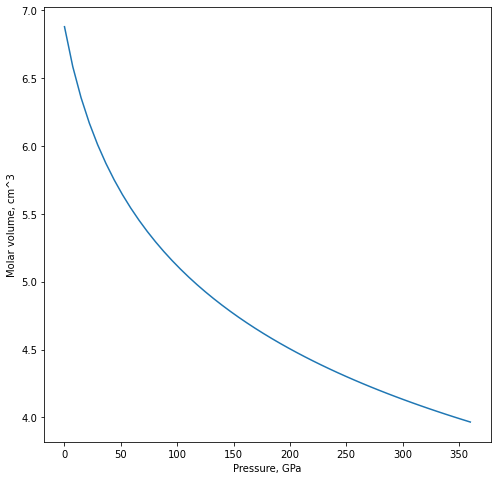

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_fe_liquid_298)
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
# ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
plt.show()

In [6]:
@numba.jit
def thermal_expansion(v, v0, a0, ag0, k):
    """
    Parameterisation of thermal expansion with pressure
    
    Uses Anderson-Gruneisen parameter. v is the volume
    of interest (i.e. at some pressure), v0 is the reference
    volume, a0 is the reference thermal expansivity, ag0
    is the 1 bar Anderson-Gruneisen parameter, k is a 
    dimensionless parameter.
    EQ5 of K14
    """
    a = a0 * np.exp(-1.0 * (ag0/k) * (1.0 - (v / v0)**k))
    return a

@numba.jit
def expand_volume(v, t, v0, a0, ag0, k):
    """
    Calculate thermal expansion and apply to 'cold' volume by integration
    
    v should be volume at 298 K. Integrate alpha = 1/V dV/dT to 
    find v at temperature T. However, alpha depends on V so iterate.
    """
    
    # Maybe we should integrate thus:
    #dt = 50.0 # K
    #for ti in np.arange(298.0, t, dt):
    #    a = thermal_expansion(v, v0, a0, ag0, k)
    #    v = v + v*a*dt
    # however, this blows up as the volume becomes bigger than v0
    # (i.e. at low pressure) since the feedback on v/v0 quickly
    # gives a floating point overflow and chaos ensues...
    # instead jusr assume that v is cold v at pressure...
    a = thermal_expansion(v, v0, a0, ag0, k)
    dt = t - 298.0
    v = v + v*a*dt
    
    return v

In [7]:
t = 5000.0

v_fe_liquid_hot = expand_volume(v_fe_liquid_298, t, fe_liquid_v0, fe_liquid_a0, fe_liquid_ag0, fe_liquid_k)

v_fe_hcp_hot = expand_volume(vinet_eos_volumes(ps, fe_hcp_v0, fe_hcp_k0, fe_hcp_kp),
                              t, fe_hcp_v0, fe_hcp_a0, fe_hcp_ag0, fe_hcp_k)
v_feo_solid_hot = expand_volume(vinet_eos_volumes(ps, feo_solid_v0, feo_solid_k0, feo_solid_kp),
                                 t, feo_solid_v0, feo_solid_a0, feo_solid_ag0, feo_solid_k)
v_feo_liquid_hot = expand_volume(vinet_eos_volumes(ps, feo_liquid_v0, feo_liquid_k0, feo_liquid_kp), 
                                  t, feo_liquid_v0, feo_liquid_a0, feo_liquid_ag0, feo_liquid_k)

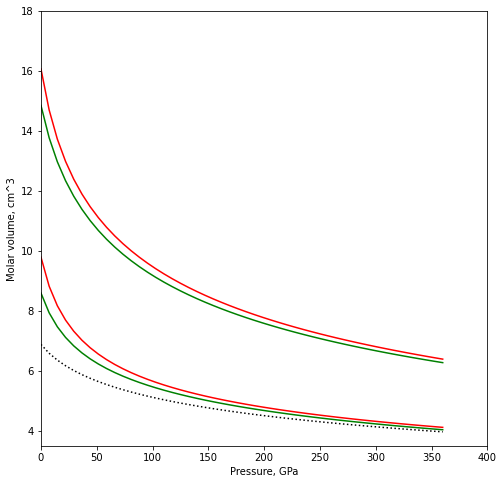

In [8]:
# The plot below looks very like K14 Figure 2 except 
# that Fe liquid at 0 GPa should have a volume > 10 

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, v_fe_liquid_298, 'k:')
ax.plot(ps, v_fe_liquid_hot, 'r')
ax.plot(ps, v_fe_hcp_hot, 'g')
ax.plot(ps, v_feo_liquid_hot, 'r')
ax.plot(ps, v_feo_solid_hot, 'g')
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Molar volume, cm^3')
ax.set_ylim([3.5,18.0]) # Match K14, Figure 2
ax.set_xlim([0.0,400.0]) # Match K14, Figure 2

plt.show()

# End member free energy

Steps 1 and 4

In [9]:
def end_member_free_energy(p, t, a, b, c, d, e, f, v0, k0, kp, a0, ag0, k):
    num_points = 500
    ps = np.linspace(0.0001, p, num_points) # in GPa
    vs = vinet_eos_volumes(ps, v0, k0, kp)
    vs = expand_volume(vs, t, v0, a0, ag0, k) # in cm^3/mol
    # Worry about units here??? GPa and cm^3?
    vdp = np.trapz(vs * 1.0E-6, ps * 1.0E9) # convert to m^3 and Pa -> J
    g_onebar = free_energy_onebar(t, a, b, c, d, e, f)
    g_pt = g_onebar + vdp
    return g_pt

@numba.jit
def free_energy_onebar(t, a, b, c, d, e, f):
    g_onebar = a + b*t + c*t*np.log(t) + \
               d*(t**2.0) + e*(t**-1.0) + f*(t**0.5)
    return g_onebar

In [10]:
gpt = end_member_free_energy(300, 5000, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                             fe_liquid_d, fe_liquid_e, fe_liquid_f,
                             fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                             fe_liquid_a0, fe_liquid_ag0, fe_liquid_k)
print('Free energy of liquid Fe at 5000 K and 300 GPa is', gpt/1000.0, 'kJ/mol')


Free energy of liquid Fe at 5000 K and 300 GPa is 1142.768977262631 kJ/mol


In [11]:
def end_member_delta_g(t, p, liquid_a, liquid_b, liquid_c, liquid_d, liquid_e, liquid_f,
                       liquid_v0, liquid_k0, liquid_kp, liquid_a0, liquid_ag0, liquid_k,
                       solid_a, solid_b, solid_c, solid_d, solid_e, solid_f,
                       solid_v0, solid_k0, solid_kp, solid_a0, solid_ag0, solid_k):
    """
    Difference in free energy (in J/mol) between solid and liquid at temperature t (in K)
    and pressure p (in GPa)
    
    NB: order of t and p reversed for use in end_member_melting_temperature
    """
    solid_g = end_member_free_energy(p, t, solid_a, solid_b, solid_c, solid_d, solid_e, solid_f,
                       solid_v0, solid_k0, solid_kp, solid_a0, solid_ag0, solid_k)
    liquid_g = end_member_free_energy(p, t, liquid_a, liquid_b, liquid_c, liquid_d, liquid_e, liquid_f,
                       liquid_v0, liquid_k0, liquid_kp, liquid_a0, liquid_ag0, liquid_k)
    return solid_g - liquid_g

    
def end_member_melting_temperature(p, liquid_a, liquid_b, liquid_c, liquid_d, liquid_e, liquid_f,
                       liquid_v0, liquid_k0, liquid_kp, liquid_a0, liquid_ag0, liquid_k,
                       solid_a, solid_b, solid_c, solid_d, solid_e, solid_f,
                       solid_v0, solid_k0, solid_kp, solid_a0, solid_ag0, solid_k):
    """
    Find the melting temperature of end members (in K) at pressure p (in GPa)
    
    Works by finding the point where the free energies are equal.
    """
    tm = spo.brentq(end_member_delta_g, 298.0, 15000.0,
                    args=(p, liquid_a, liquid_b, liquid_c, liquid_d, liquid_e, liquid_f,
                          liquid_v0, liquid_k0, liquid_kp, liquid_a0, liquid_ag0, liquid_k,
                          solid_a, solid_b, solid_c, solid_d, solid_e, solid_f,
                          solid_v0, solid_k0, solid_kp, solid_a0, solid_ag0, solid_k))
    return tm

end_member_melting_temperatures = np.vectorize(end_member_melting_temperature)

In [12]:
ps = np.linspace(0.0, 350.0)

feo_tms = end_member_melting_temperatures(ps, feo_liquid_a, feo_liquid_b, feo_liquid_c, 
                                          feo_liquid_d, feo_liquid_e, feo_liquid_f,
                                          feo_liquid_v0, feo_liquid_k0, feo_liquid_kp,
                                          feo_liquid_a0, feo_liquid_ag0, feo_liquid_k,
                                          feo_solid_a, feo_solid_b, feo_solid_c, 
                                          feo_solid_d, feo_solid_e, feo_solid_f,
                                          feo_solid_v0, feo_solid_k0, feo_solid_kp,
                                          feo_solid_a0, feo_solid_ag0, feo_solid_k)

fe_tms = end_member_melting_temperatures(ps, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                                          fe_liquid_d, fe_liquid_e, fe_liquid_f,
                                          fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                                          fe_liquid_a0, fe_liquid_ag0, fe_liquid_k,
                                          fe_hcp_a, fe_hcp_b, fe_hcp_c, 
                                          fe_hcp_d, fe_hcp_e, fe_hcp_f,
                                          fe_hcp_v0, fe_hcp_k0, fe_hcp_kp,
                                          fe_hcp_a0, fe_hcp_ag0, fe_hcp_k)

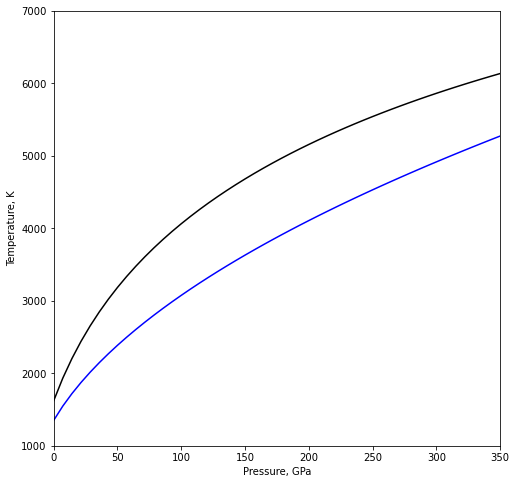

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(ps, feo_tms, 'k')
ax.plot(ps, fe_tms, 'b')
ax.set_xlabel('Pressure, GPa')
ax.set_ylabel('Temperature, K')
ax.set_ylim([1000.0,7000.0]) 
ax.set_xlim([0.0,350.0])

plt.show()

## Ideal solution

Step 6 (for liquid)

In [14]:
def chemical_potential(x, p, t, a, b, c, d, e, f, v0, k0, kp, a0, ag0, k):
    mu_0 = end_member_free_energy(p, t, a, b, c, d, e, f, v0, k0, kp, a0, ag0, k)
    activity = x # ideal solution - could implement non-ideal here 
                 # but not good at ICB pressure
    r = 8.31446261815324 # gas constant J/K/mol
    mu = mu_0 + r * t * np.log(activity)
    return mu

def liquid_free_energy(x_fe, p, t):
    x_feo = 1.0 - x_fe
    
    if x_fe != 0.0:
        mu_fe = chemical_potential(x_fe, p, t, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                                   fe_liquid_d, fe_liquid_e, fe_liquid_f,
                                   fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                                   fe_liquid_a0, fe_liquid_ag0, fe_liquid_k)
    
    if x_feo != 0.0:
        mu_feo = chemical_potential(x_feo, p, t, feo_liquid_a, feo_liquid_b, feo_liquid_c, 
                                    feo_liquid_d, feo_liquid_e, feo_liquid_f,
                                    feo_liquid_v0, feo_liquid_k0, feo_liquid_kp,
                                    feo_liquid_a0, feo_liquid_ag0, feo_liquid_k)
    
    if x_fe == 0.0:
        g = end_member_free_energy(p, t, feo_liquid_a, feo_liquid_b, feo_liquid_c, 
                                  feo_liquid_d, feo_liquid_e, feo_liquid_f,
                                  feo_liquid_v0, feo_liquid_k0, feo_liquid_kp,
                                  feo_liquid_a0, feo_liquid_ag0, feo_liquid_k)
    elif x_feo == 0.0:
        g = end_member_free_energy(p, t, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                                   fe_liquid_d, fe_liquid_e, fe_liquid_f,
                                   fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                                   fe_liquid_a0, fe_liquid_ag0, fe_liquid_k)
    else:
        g = x_fe*mu_fe + x_feo*mu_feo

    return g


# Avoid hand coding loops. 
liquid_free_energies = np.vectorize(liquid_free_energy)

In [15]:
p = 330.0
x_l = np.linspace(0.0, 1.0)
ts = [7000.0, 6000.0, 5000.0, 4000.0, 3000.0]
g_l = []
g_feo = []
g_fe = []
g_solid_mixture = []
mu_fe_l = []
mu_feo_l = []
for t in ts:
    g_l.append(liquid_free_energies(x_l, p, t))
    g_feo_t = (end_member_free_energy(p, t, feo_solid_a, feo_solid_b, feo_solid_c, 
                                      feo_solid_d, feo_solid_e, feo_solid_f,
                                      feo_solid_v0, feo_solid_k0, feo_solid_kp,
                                      feo_solid_a0, feo_solid_ag0, feo_solid_k))
    g_feo.append(g_feo_t)
    g_fe_t = (end_member_free_energy(p, t, fe_hcp_a, fe_hcp_b, fe_hcp_c, 
                                     fe_hcp_d, fe_hcp_e, fe_hcp_f,
                                     fe_hcp_v0, fe_hcp_k0, fe_hcp_kp,
                                     fe_hcp_a0, fe_hcp_ag0, fe_hcp_k))
    g_fe.append(g_fe_t)
    g_solid_mixture.append(x_l*g_fe_t + (1.0 - x_l)*g_feo_t)
    
    mu_fe_l.append(chemical_potential(x_l[1:], p, t, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                                fe_liquid_d, fe_liquid_e, fe_liquid_f,
                                fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                                fe_liquid_a0, fe_liquid_ag0, fe_liquid_k))
    mu_feo_l.append(chemical_potential(1.0-x_l[:-1], p, t, feo_liquid_a, feo_liquid_b, feo_liquid_c, 
                                  feo_liquid_d, feo_liquid_e, feo_liquid_f,
                                  feo_liquid_v0, feo_liquid_k0, feo_liquid_kp,
                                  feo_liquid_a0, feo_liquid_ag0, feo_liquid_k))
    
    

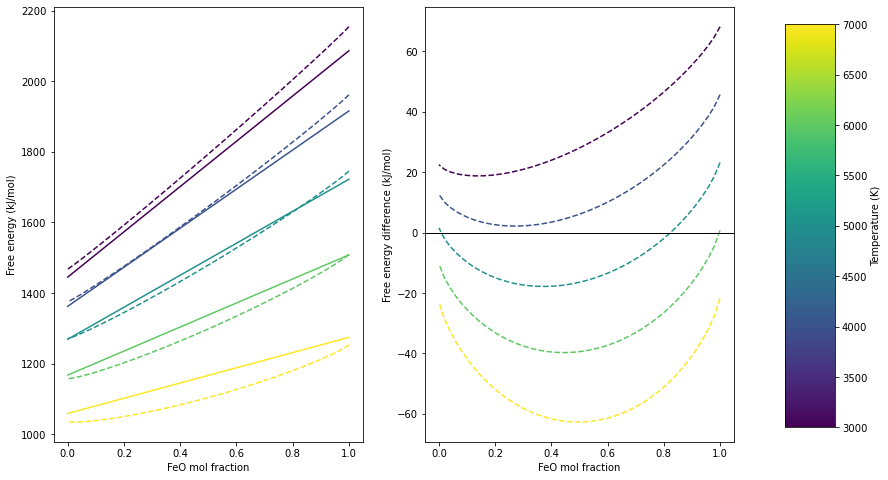

In [16]:
fig, axs = plt.subplots(figsize=(14,8), ncols=2)
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    axs[0].plot(1.0-x_l, g_l[ii]/1000, '--', color=cmap.to_rgba(t))
    axs[0].plot(1.0-x_l, g_solid_mixture[ii]/1000, '-', color=cmap.to_rgba(t))
    
    axs[1].plot(1.0-x_l, (g_l[ii] - g_solid_mixture[ii])/1000, '--', color=cmap.to_rgba(t))
    axs[1].axhline(color='k', lw=1)
    

axs[0].set_xlabel('FeO mol fraction')
axs[0].set_ylabel('Free energy (kJ/mol)')
axs[1].set_xlabel('FeO mol fraction')
axs[1].set_ylabel('Free energy difference (kJ/mol)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()

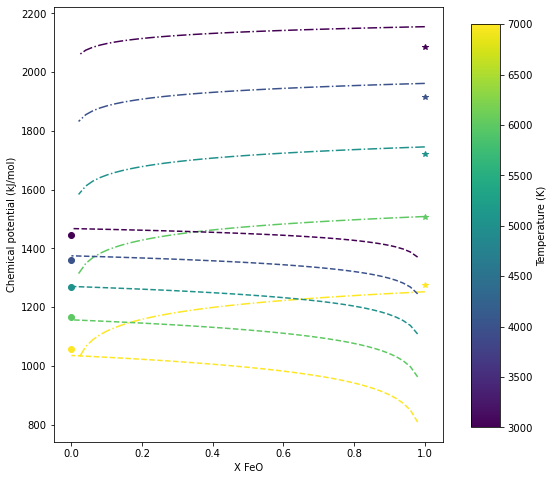

In [17]:
fig, ax = plt.subplots(figsize=(8,8))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))

for ii, t in enumerate(ts):
    ax.plot(1.0-x_l[1:], mu_fe_l[ii]/1000, '--', color=cmap.to_rgba(t))
    ax.plot(0.0, g_fe[ii]/1000, 'o', color=cmap.to_rgba(t))
    ax.plot(1.0-x_l[:-1], mu_feo_l[ii]/1000, '-.', color=cmap.to_rgba(t))
    ax.plot(1.0, g_feo[ii]/1000, '*', color=cmap.to_rgba(t))
    
ax.set_xlabel('X FeO')
ax.set_ylabel('Chemical potential (kJ/mol)')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')

plt.show()

In [18]:
def _delta_mu_fe_liquid(x, p, t, gsolid):
    mu_fe_liquid = chemical_potential(x, p, t, fe_liquid_a, fe_liquid_b, fe_liquid_c, 
                                fe_liquid_d, fe_liquid_e, fe_liquid_f,
                                fe_liquid_v0, fe_liquid_k0, fe_liquid_kp,
                                fe_liquid_a0, fe_liquid_ag0, fe_liquid_k) 
    delta_mu = mu_fe_liquid - gsolid
    return delta_mu

def _delta_mu_feo_liquid(x, p, t, gsolid):
    mu_feo_liquid = chemical_potential(1.0-x, p, t, feo_liquid_a, feo_liquid_b, feo_liquid_c, 
                                  feo_liquid_d, feo_liquid_e, feo_liquid_f,
                                  feo_liquid_v0, feo_liquid_k0, feo_liquid_kp,
                                  feo_liquid_a0, feo_liquid_ag0, feo_liquid_k) 
    delta_mu = mu_feo_liquid - gsolid
    return delta_mu
    

def find_liquidus(p, t):
    """
    At some Ps and Ts we should have two liquidus compositions 
    (one on each side of the eutectic). These are the compositions
    for the liquid where mu_liquid == mu_solid for Fe or FeO, 
    respectivly
    """
    g_fe_solid = end_member_free_energy(p, t, fe_hcp_a, fe_hcp_b, fe_hcp_c, 
                                          fe_hcp_d, fe_hcp_e, fe_hcp_f,
                                          fe_hcp_v0, fe_hcp_k0, fe_hcp_kp,
                                          fe_hcp_a0, fe_hcp_ag0, fe_hcp_k)
    if _delta_mu_fe_liquid(1.0, p, t, g_fe_solid) <= 0.0:
        x_fe_side = 1.0 # above pure phase melting T
    else:
        x_fe_side = spo.brentq(_delta_mu_fe_liquid, 0.000000001, 1.0, args=(p, t, g_fe_solid))

        
    g_feo_solid = end_member_free_energy(p, t, feo_solid_a, feo_solid_b, feo_solid_c, 
                                          feo_solid_d, feo_solid_e, feo_solid_f,
                                          feo_solid_v0, feo_solid_k0, feo_solid_kp,
                                          feo_solid_a0, feo_solid_ag0, feo_solid_k)
    if _delta_mu_feo_liquid(0.0, p, t, g_feo_solid) <= 0.0:
        x_feo_side = 0.0 # above pure phase melting T
    else:
        x_feo_side = spo.brentq(_delta_mu_feo_liquid, 0.0, 0.999999999, args=(p, t, g_feo_solid))
        
    if x_fe_side < x_feo_side:
        # below eutectic?
        x_fe_side = 0.0
        x_feo_side = 1.0
        
    return x_fe_side , x_feo_side



In [19]:
p1 = 330.0
p2 = 220.0
p3 = 136.0
ts = np.linspace(2500, 6500, 200)
x11 = np.zeros_like(ts)
x21 = np.zeros_like(ts)
x12 = np.zeros_like(ts)
x22 = np.zeros_like(ts)
x13 = np.zeros_like(ts)
x23 = np.zeros_like(ts)

for i, t in enumerate(ts):
    x11[i], x21[i] = find_liquidus(p1, t)
    x12[i], x22[i] = find_liquidus(p2, t)
    x13[i], x23[i] = find_liquidus(p3, t)

In [20]:
def mol_to_mass(molfrac):
    o_mass = 15.999
    fe_mass = 55.845
    total_mass = (o_mass+fe_mass)*molfrac + fe_mass*(1.0-molfrac)
    massfrac = o_mass*molfrac / total_mass
    return massfrac * 100.0

def mass_to_mol(wtpc):
    # Something wrong!
    o_mass = 15.999
    fe_mass = 55.845
    mol_o = (wtpc/100.0) / o_mass
    mol_fe = ((100.0-wtpc)/100.0) / fe_mass
    molfrac = 2.0*mol_o / (mol_o + mol_fe)
    return molfrac

In [21]:
print(mol_to_mass(1.0))
print(mass_to_mol(22.27))
print(mol_to_mass(0.0))
print(mass_to_mol(0.0))
print(mol_to_mass(0.5))
print(mass_to_mol(12.5))

22.26908301319526
1.0000264868666753
0.0
0.0
12.529661912929072
0.6654631251564008


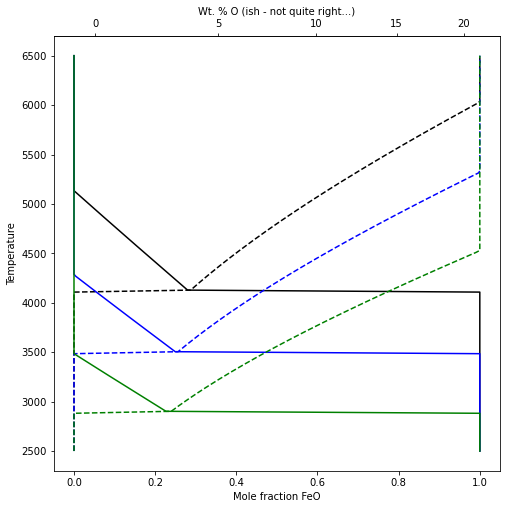

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
# flip Fe-FeO direction for plot
ax.plot(1.0-x11, ts, 'k')
ax.plot(1.0-x21, ts, 'k--')

ax.plot(1.0-x12, ts, 'b')
ax.plot(1.0-x22, ts, 'b--')

ax.plot(1.0-x13, ts, 'g')
ax.plot(1.0-x23, ts, 'g--')

ax.set_xlabel('Mole fraction FeO')
ax.set_ylabel('Temperature')

secax = ax.secondary_xaxis('top', functions=(mol_to_mass, mass_to_mol))
secax.set_xlabel('Wt. % O (ish - not quite right...)')

plt.show()